# ML/DL for Everyone

### 출처

- 모두를 위한 딥러닝 시즌2
- 링크: [모두를 위한 딥러닝 시즌2](https://www.youtube.com/watch?v=7eldOrjQVi0&list=PLQ28Nx3M4Jrguyuwg4xe9d9t2XE639e5C)

<br/>

## Softmax Classification

<hr/>

### 패키지 import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# 재현성 
torch.manual_seed(1)

<br/>

### 이산 확률 분포 Discrete Probability Distribution

- 이산적인 확률 분포를 이용해 머신러닝 수행

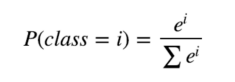

<br/>

$$ 0.09 = \frac{e^1}{e^1 + e^2 + e^3} ,  0.2447 = \frac{e^2}{e^1 + e^2 + e^3} ,  0.6652 = \frac{e^3}{e^1 + e^2 + e^3}$$ 

In [3]:
z = torch.FloatTensor([1, 2, 3])

hypothesis = F.softmax(z, dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


In [4]:
hypothesis.sum()

tensor(1.)

위에서 1, 2, 3이 차례대로 가위, 바위, 보라고 했을 때 $ P(보|가위) = 0.6652 $ 라고 볼 수 있다. (66.52%)

<br/><br/>

### Cross Entropy

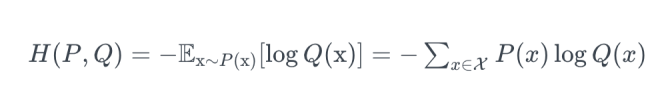

- cross entropy를 최소화하는 것이 중요

<br/>

#### Cross Entropy Loss(Low-level)

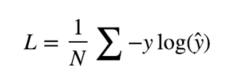

In [10]:
z = torch.rand(3, 5, requires_grad=True)
print(z)

tensor([[0.2616, 0.7713, 0.3785, 0.9980, 0.9008],
        [0.4766, 0.1663, 0.8045, 0.6552, 0.1768],
        [0.8248, 0.8036, 0.9434, 0.2197, 0.4177]], requires_grad=True)


In [11]:
hypothesis = F.softmax(z, dim=1) 
print(hypothesis)

tensor([[0.1287, 0.2142, 0.1446, 0.2687, 0.2438],
        [0.1977, 0.1450, 0.2744, 0.2364, 0.1465],
        [0.2317, 0.2268, 0.2609, 0.1265, 0.1542]], grad_fn=<SoftmaxBackward0>)


In [12]:
y = torch.randint(5, (3,)).long()
print(y)

tensor([1, 2, 2])


- Classes의 개수 = 5개 <br/>
- Samples의 개수 = 3개

<br/>

#### ont-hot 벡터 표현

- y.unsqueeze(1)를 통해 y가 (1,3)에서 y(3,1)로 변경됨<br/>
$ \begin{bmatrix}1&2&2 \end{bmatrix} $ ==>> $ \begin{bmatrix}1\\2\\2 \end{bmatrix} $ 

<br/>

- scatter_()는 '_'가 포함되어 있어 in place 함수로 쓰인다. 즉, y_one_hot에 그대로 값이 교체되어 들어감

In [16]:
y_one_hot = torch.zeros_like(hypothesis)
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])

**아래 벡터의 사이즈**
- y_one_hot: (3, 5)
- hypothesis: (3, 5)

로 동일하다

In [20]:
(y_one_hot * -torch.log(hypothesis))

tensor([[0.0000, 1.5408, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.2930, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.3438, 0.0000, 0.0000]], grad_fn=<MulBackward0>)

In [21]:
(y_one_hot * -torch.log(hypothesis)).sum(dim=1)

tensor([1.5408, 1.2930, 1.3438], grad_fn=<SumBackward1>)

In [19]:
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.3926, grad_fn=<MeanBackward0>)


<br/>

### Cross-entropy Loss with torch.nn.functional

- torch.nn.functional 라이브러리를 사용하면 위의 과정을 좀 더 쉽게 작성할 수 있다

In [22]:
# Low level
torch.log(F.softmax(z, dim=1))

tensor([[-2.0505, -1.5408, -1.9337, -1.3141, -1.4114],
        [-1.6209, -1.9313, -1.2930, -1.4423, -1.9207],
        [-1.4625, -1.4837, -1.3438, -2.0675, -1.8696]], grad_fn=<LogBackward0>)

In [23]:
# High level
F.log_softmax(z, dim=1)

tensor([[-2.0505, -1.5408, -1.9337, -1.3141, -1.4114],
        [-1.6209, -1.9313, -1.2930, -1.4423, -1.9207],
        [-1.4625, -1.4837, -1.3438, -2.0675, -1.8696]],
       grad_fn=<LogSoftmaxBackward0>)

In [26]:
# Low level
(y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

tensor(1.3926, grad_fn=<MeanBackward0>)

In [27]:
# High level
F.nll_loss(F.log_softmax(z, dim=1), y)

tensor(1.3926, grad_fn=<NllLossBackward0>)

위에서 **NLL**은 "Negative Log Likelihood"의 약자이다.<br/>
cross_entropy()함수를 사용하면 보다 간편하게 결과값을 얻을 수도 있다.

In [28]:
F.cross_entropy(z, y)

tensor(1.3926, grad_fn=<NllLossBackward0>)

<br/>

### Training with Low-level Cross Entropy Loss

- samples = m<br/>
- classes = 3<br/>
- dim=4

In [29]:
x_train = [[1, 2, 1, 1],
          [2, 1, 3, 2],
          [3, 1, 3, 4],
          [4, 1, 5, 5],
          [1, 7, 5, 5],
          [1, 2, 5, 6],
          [1, 6, 6, 6],
          [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]

x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

In [30]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산 (1)
    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1) # or .mm or @
    y_one_hot = torch.zeros_like(hypothesis)
    y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
    cost = (y_one_hot * -torch.log(F.softmax(hypothesis, dim=1))).sum(dim=1).mean()

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.901535
Epoch  200/1000 Cost: 0.839114
Epoch  300/1000 Cost: 0.807826
Epoch  400/1000 Cost: 0.788472
Epoch  500/1000 Cost: 0.774822
Epoch  600/1000 Cost: 0.764449
Epoch  700/1000 Cost: 0.756191
Epoch  800/1000 Cost: 0.749398
Epoch  900/1000 Cost: 0.743671
Epoch 1000/1000 Cost: 0.738749


<br/>

### Training with F.cross_entropy

- scatter가 필요없다

In [32]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산 (2)
    z = x_train.matmul(W) + b # or .mm or @
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568255
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


<br/>

### High-level Implementation with nn.Module

- 실전에 가까운 버전
- 샘플 개수: 4개, 출력 개수: 3개
- linear layer를 통과시킨 결과: $ |x| = (m, 4)  ==>> (m,3) $

In [34]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3) # 출력이 3개 이다.
        
    def forward(self, x):
        return self.linear(x)

In [36]:
model = SoftmaxClassifierModel()

# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.823884
Epoch  100/1000 Cost: 0.678397
Epoch  200/1000 Cost: 0.589243
Epoch  300/1000 Cost: 0.532537
Epoch  400/1000 Cost: 0.486882
Epoch  500/1000 Cost: 0.446686
Epoch  600/1000 Cost: 0.409545
Epoch  700/1000 Cost: 0.373977
Epoch  800/1000 Cost: 0.338811
Epoch  900/1000 Cost: 0.303093
Epoch 1000/1000 Cost: 0.266941


- $ |x\_train| = (m, 4) $
- $ |prediction| = (m, 3) $
- $ |y\_train| = (m,) $

<br/>

### 정리

**Logistic Regression**은 0과 1 두 가지 클래스, 즉 이산적인 클래스가 있는 classification(분류)이다.<br/>
반면, **Softmax classification**은 multinary 또는 multinomial 확률분포이다. (다변수)
<br/><br/>

- **Binary Classification**을 할 때는 **binary cross entropy loss**와 **Sigmoid**를 사용
- 여러 개의 클래스가 있다면 **cross entropy loss**와 **softmax**를 사용